# P2 Milestone

## Was Maslow's Hierarchy of Needs dismantled during the COVID-19 pandemic?
Maslow's Hierarchy of Needs serves as a model for assessing human behavior. We clearly
observed a shift in behavior during the pandemic. Now, we must ask: were the blocks of the
pyramid also rearranged? By analyzing the mobility report alongside Wikipedia searches, we
aim to explore whether the hierarchy of needs remains unchanged or if it needs redefinition. We
will also try to draw a link between the blocks of the pyramid and the mobility patterns. For
example, groceries and pharmacy represent physiological needs, safety needs may include
residential or job security, love and belonging could be related to relationships and
transportation to see loved ones, and esteem can be associated with employment, and
self-actualization. Self-actualization, at the top of Maslow's Hierarchy, involves personal and
professional growth, creativity, and a deeper sense of purpose. This process may lead to a
renewed appreciation for Maslow's work or reveal new insights into human motivation during
these unique times.

![Image Alt Text](maslow.jpg)

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from helpers import *
import plotly.express as px
from datetime import datetime
import statsmodels.formula.api as smf

## Regions Dataframe (External Dataframe)

Dataframe containing countriess with their region code, and the continent that they're located in

In [191]:
dfRegions=pd.read_csv('DATA/New Data/regions.csv')
dfRegions = dfRegions.loc[:,['name', 'region', 'alpha-2']]
dfRegions

,name,region,alpha-2
0,Afghanistan,Asia,AF
1,Åland Islands,Europe,AX
2,Albania,Europe,AL
3,Algeria,Africa,DZ
4,American Samoa,Oceania,AS
...,...,...,...
244,Wallis and Futuna,Oceania,WF
245,Western Sahara,Africa,EH
246,Yemen,Asia,YE
247,Zambia,Africa,ZM


Splitting the previous dataframe by continent

In [192]:
continents = dfRegions['region'].unique()
continents = continents[:-1]
print(continents)
dfsContinents = []
for continent in continents :
    dfsContinents.append(dfRegions[dfRegions['region'] == continent].copy())


['Asia' 'Europe' 'Africa' 'Oceania' 'Americas']


## Interventions 

In [193]:
interventions=pd.read_csv('DATA/interventions.csv')
interventions=process_interventions(interventions)
interventions.dtypes
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24 00:00:00,2020-02-14 00:00:00,2020-03-14 00:00:00,2020-03-13 00:00:00,2020-03-17 00:00:00,2020-03-16 00:00:00,2020-07-02 00:00:00
1,da,2020-02-27 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-12 00:00:00,2020-03-18 00:00:00,2020-03-11 00:00:00,2020-06-05 00:00:00
2,de,2020-01-27 00:00:00,2020-03-09 00:00:00,2020-03-14 00:00:00,2020-03-22 00:00:00,2020-03-22 00:00:00,2020-03-16 00:00:00,2020-07-10 00:00:00
3,it,2020-01-31 00:00:00,2020-02-22 00:00:00,2020-03-05 00:00:00,2020-03-09 00:00:00,2020-03-11 00:00:00,2020-03-11 00:00:00,2020-06-26 00:00:00
4,nl,2020-02-27 00:00:00,2020-03-06 00:00:00,2020-03-11 00:00:00,2020-03-24 00:00:00,NaT,2020-03-16 00:00:00,2020-05-29 00:00:00
5,no,2020-02-26 00:00:00,2020-02-26 00:00:00,2020-03-13 00:00:00,2020-03-12 00:00:00,2020-03-24 00:00:00,2020-03-11 00:00:00,2020-06-04 00:00:00
6,sr,2020-03-06 00:00:00,2020-03-20 00:00:00,2020-03-15 00:00:00,2020-03-21 00:00:00,2020-03-21 00:00:00,2020-03-16 00:00:00,2020-05-02 00:00:00
7,sv,2020-01-31 00:00:00,2020-03-11 00:00:00,2020-03-18 00:00:00,2020-03-12 00:00:00,NaT,2020-03-11 00:00:00,2020-06-05 00:00:00
8,ko,2020-01-20 00:00:00,2020-02-20 00:00:00,2020-02-23 00:00:00,NaT,NaT,2020-02-25 00:00:00,2020-04-15 00:00:00
9,ca,2020-01-31 00:00:00,2020-02-13 00:00:00,2020-03-12 00:00:00,2020-03-08 00:00:00,2020-03-14 00:00:00,2020-03-16 00:00:00,NaT


In [194]:
interventions['Lockdown']
interventions['Lockdown'] = pd.to_datetime(interventions['Lockdown'], format='%Y-%m-%d')
interventions['Public events banned'] = pd.to_datetime(interventions['Public events banned'], format='%Y-%m-%d')
interventions['Mobility'] = pd.to_datetime(interventions['Mobility'], format='%Y-%m-%d')

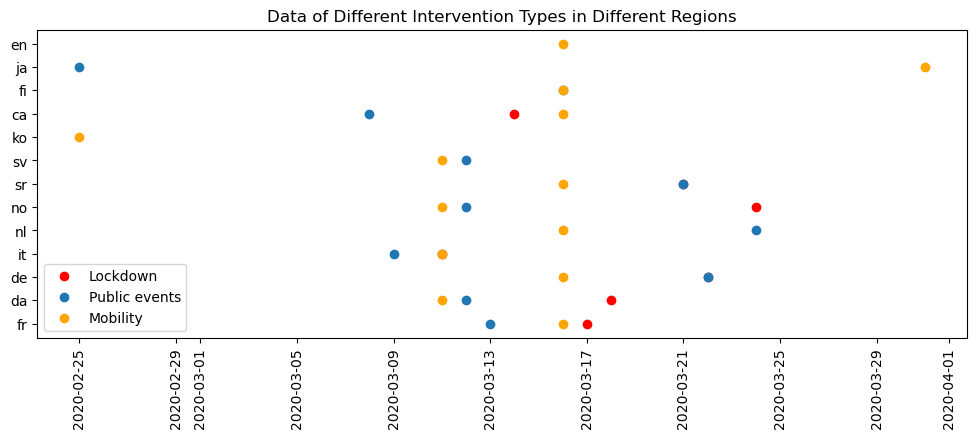

In [195]:
plt.figure(figsize=(12,4))
plt.scatter(interventions['Lockdown'],interventions['lang'],color='red',label='Lockdown')
plt.scatter(interventions['Public events banned'],interventions['lang'],label='Public events')
plt.scatter(interventions['Mobility'],interventions['lang'],color='orange',label='Mobility')
plt.legend()
plt.xticks(rotation=90)
plt.title('Data of Different Intervention Types in Different Regions')
plt.show()


In [196]:
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24 00:00:00,2020-02-14 00:00:00,2020-03-14 00:00:00,2020-03-13,2020-03-17,2020-03-16,2020-07-02 00:00:00
1,da,2020-02-27 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-12,2020-03-18,2020-03-11,2020-06-05 00:00:00
2,de,2020-01-27 00:00:00,2020-03-09 00:00:00,2020-03-14 00:00:00,2020-03-22,2020-03-22,2020-03-16,2020-07-10 00:00:00
3,it,2020-01-31 00:00:00,2020-02-22 00:00:00,2020-03-05 00:00:00,2020-03-09,2020-03-11,2020-03-11,2020-06-26 00:00:00
4,nl,2020-02-27 00:00:00,2020-03-06 00:00:00,2020-03-11 00:00:00,2020-03-24,NaT,2020-03-16,2020-05-29 00:00:00
5,no,2020-02-26 00:00:00,2020-02-26 00:00:00,2020-03-13 00:00:00,2020-03-12,2020-03-24,2020-03-11,2020-06-04 00:00:00
6,sr,2020-03-06 00:00:00,2020-03-20 00:00:00,2020-03-15 00:00:00,2020-03-21,2020-03-21,2020-03-16,2020-05-02 00:00:00
7,sv,2020-01-31 00:00:00,2020-03-11 00:00:00,2020-03-18 00:00:00,2020-03-12,NaT,2020-03-11,2020-06-05 00:00:00
8,ko,2020-01-20 00:00:00,2020-02-20 00:00:00,2020-02-23 00:00:00,NaT,NaT,2020-02-25,2020-04-15 00:00:00
9,ca,2020-01-31 00:00:00,2020-02-13 00:00:00,2020-03-12 00:00:00,2020-03-08,2020-03-14,2020-03-16,NaT


## Topics linked

In [197]:
topics_linked=pd.read_csv('DATA/topics_linked.csv')
topics_linked=process_topics_linked(topics_linked)

In [198]:
topics_agg=topics_linked.select_dtypes(include='int').sum().copy()
topics_agg=topics_agg.sort_values(ascending=False)

In [199]:
topics_agg.describe()

count    6.400000e+01
mean     1.824276e+05
std      2.651203e+05
min      4.301000e+03
25%      3.186950e+04
50%      8.563600e+04
75%      1.809262e+05
max      1.403864e+06
dtype: float64

In [200]:
topics_agg.index
topics_agg

Culture.Biography.Biography*                1403864
Geography.Regions.Europe.Europe*            1008804
Culture.Media.Media*                         817879
Culture.Sports                               739892
Geography.Regions.Americas.North America     703802
                                             ...   
Geography.Regions.Africa.Western Africa       12143
Geography.Regions.Asia.Central Asia           10441
STEM.Libraries & Information                   8814
Geography.Regions.Africa.Eastern Africa        7192
Geography.Regions.Africa.Central Africa        4301
Length: 64, dtype: int64

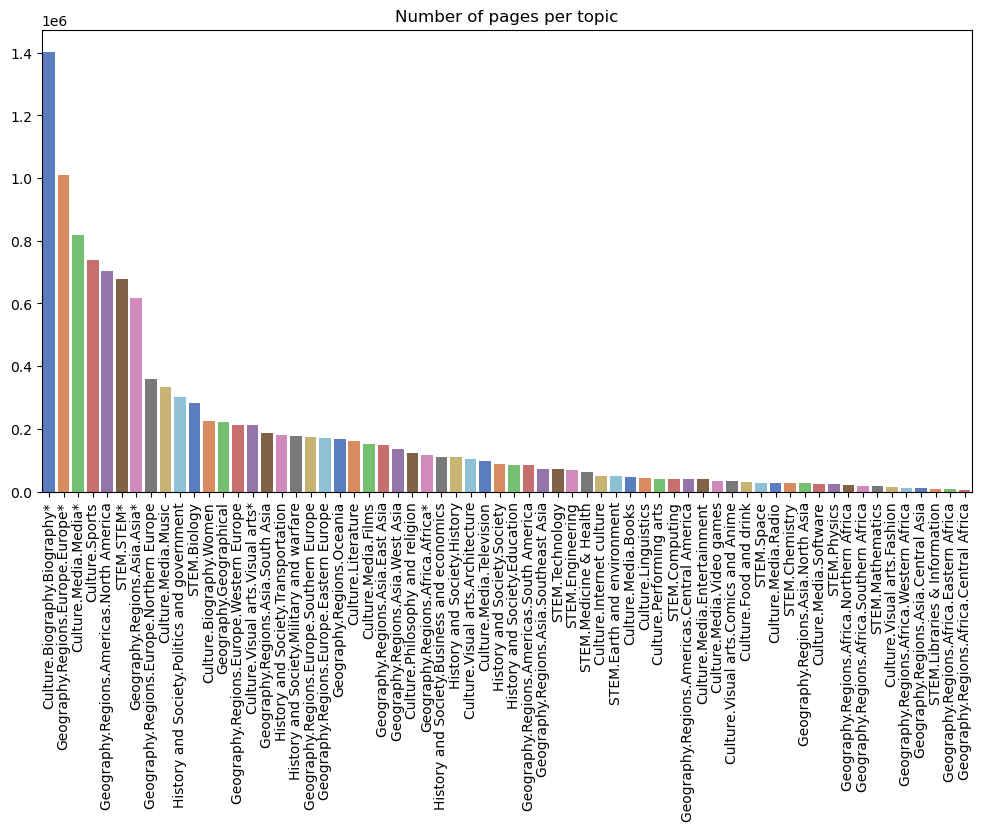

In [201]:
plt.figure(figsize=(12,6))
sns.barplot(x=topics_agg.index,y=topics_agg,palette='muted')
plt.xticks(rotation=90)
plt.title('Number of pages per topic')
plt.show()

## Aggregated time series

In [202]:
agg_ts=pd.read_json('DATA/aggregated_timeseries.json')

agg_ts


,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
len,1197788,1594039,256451,346007,516838,6047509,632128,345790,6045654,531478,...,489181,480638,396063,1197856,2195949,481854,642031,1588312,1959446,490314
sum,"{'2018-01-01 00:00:00': 22328288, '2018-01-02 ...","{'2018-01-01 00:00:00': 3338750, '2018-01-02 0...","{'2018-01-01 00:00:00': 765123, '2018-01-02 00...","{'2018-01-01 00:00:00': 407629, '2018-01-02 00...","{'2018-01-01 00:00:00': 715031, '2018-01-02 00...","{'2018-01-01 00:00:00': 86763830, '2018-01-02 ...","{'2018-01-01 00:00:00': 192409, '2018-01-02 00...","{'2018-01-01 00:00:00': 493684, '2018-01-02 00...","{'2018-01-01 00:00:00': 135822131, '2018-01-02...","{'2018-01-01 00:00:00': 224417, '2018-01-02 00...",...,"{'2018-01-01 00:00:00': 1484496, '2018-01-02 0...","{'2018-01-01 00:00:00': 1319053, '2018-01-02 0...","{'2018-01-01 00:00:00': 451383, '2018-01-02 00...","{'2018-01-01 00:00:00': 7828155, '2018-01-02 0...","{'2018-01-01 00:00:00': 6441009, '2018-01-02 0...","{'2018-01-01 00:00:00': 523135, '2018-01-02 00...","{'2018-01-01 00:00:00': 111910, '2018-01-02 00...","{'2018-01-01 00:00:00': 12856884, '2018-01-02 ...","{'2018-01-01 00:00:00': 2383474, '2018-01-02 0...","{'2018-01-01 00:00:00': 819174, '2018-01-02 00..."
covid,"{'len': 30, 'sum': {'2018-01-01 00:00:00': 55,...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 50,...","{'len': 4, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 1, ...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 7, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 57...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 6, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 3, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 91...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 2, ...",...,"{'len': 113, 'sum': {'2018-01-01 00:00:00': 6,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 11, ...","{'len': 30, 'sum': {'2018-01-01 00:00:00': 26,...","{'len': 16, 'sum': {'2018-01-01 00:00:00': 62,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 2, '...","{'len': 49, 'sum': {'2018-01-01 00:00:00': 6, ...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 139...","{'len': 8, 'sum': {'2018-01-01 00:00:00': 19, ...","{'len': 113, 'sum': {'2018-01-01 00:00:00': 3,..."
topics,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 29427...,{'Culture.Biography.Biography*': {'len': 57720...,{'Culture.Biography.Biography*': {'len': 70443...,{'Culture.Biography.Biography*': {'len': 11603...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 37718...,{'Culture.Biography.Biography*': {'len': 70434...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 11804...,...,{'Culture.Biography.Biography*': {'len': 75406...,{'Culture.Biography.Biography*': {'len': 10422...,{'Culture.Biography.Biography*': {'len': 37580...,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 38258...,{'Culture.Biography.Biography*': {'len': 10444...,{'Culture.Biography.Biography*': {'len': 10175...,{'Culture.Biography.Biography*': {'len': 29422...,{'Culture.Biography.Biography*': {'len': 14668...,{'Culture.Biography.Biography*': {'len': 75498...


#### Naive look at different topics: case Italy

General Case

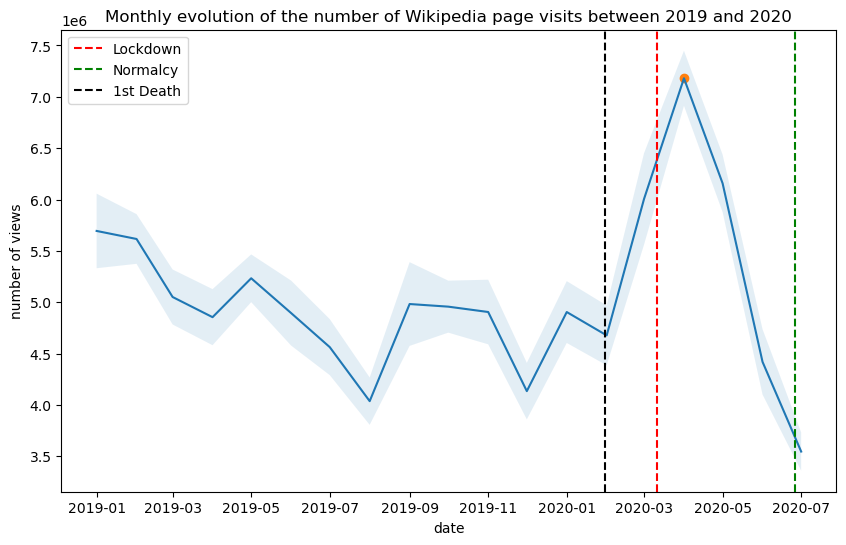

In [203]:
it=process_agg_time_series(agg_ts['it']['sum'])
it=it.loc[it['year'].isin([2020,2019])]
it_means=it.groupby(['year','month'])['sum'].mean().copy()
it_sem=it.groupby(['year','month'])['sum'].sem().copy()
it_means.index=[datetime(e[0], e[1],1) for e in it_means.index]
it_sem.index=[datetime(e[0], e[1],1) for e in it_sem.index]
CI=stats.t.interval(0.95, len(it_means)-1 , loc = it_means, scale = it_sem)
plt.figure(figsize=(10,6))
sns.lineplot(it_means)
plt.axvline(x=[interventions['Lockdown'][3]],color='red', linestyle='--', label='Lockdown')
plt.axvline(x=[interventions['Normalcy'][3]],color='green', linestyle='--', label='Normalcy')
plt.axvline(x=[interventions['1st case'][3]],color='black', linestyle='--', label='1st Death')
plt.fill_between(it_means.index,CI[0],CI[1],alpha=0.12)
plt.scatter(x=it_means.idxmax(),y=it_means.max())
plt.title('Monthly evolution of the number of Wikipedia page visits between 2019 and 2020')
plt.xlabel('date')
plt.ylabel('number of views')
plt.legend()
plt.show()

Specific case

<Figure size 1400x600 with 0 Axes>

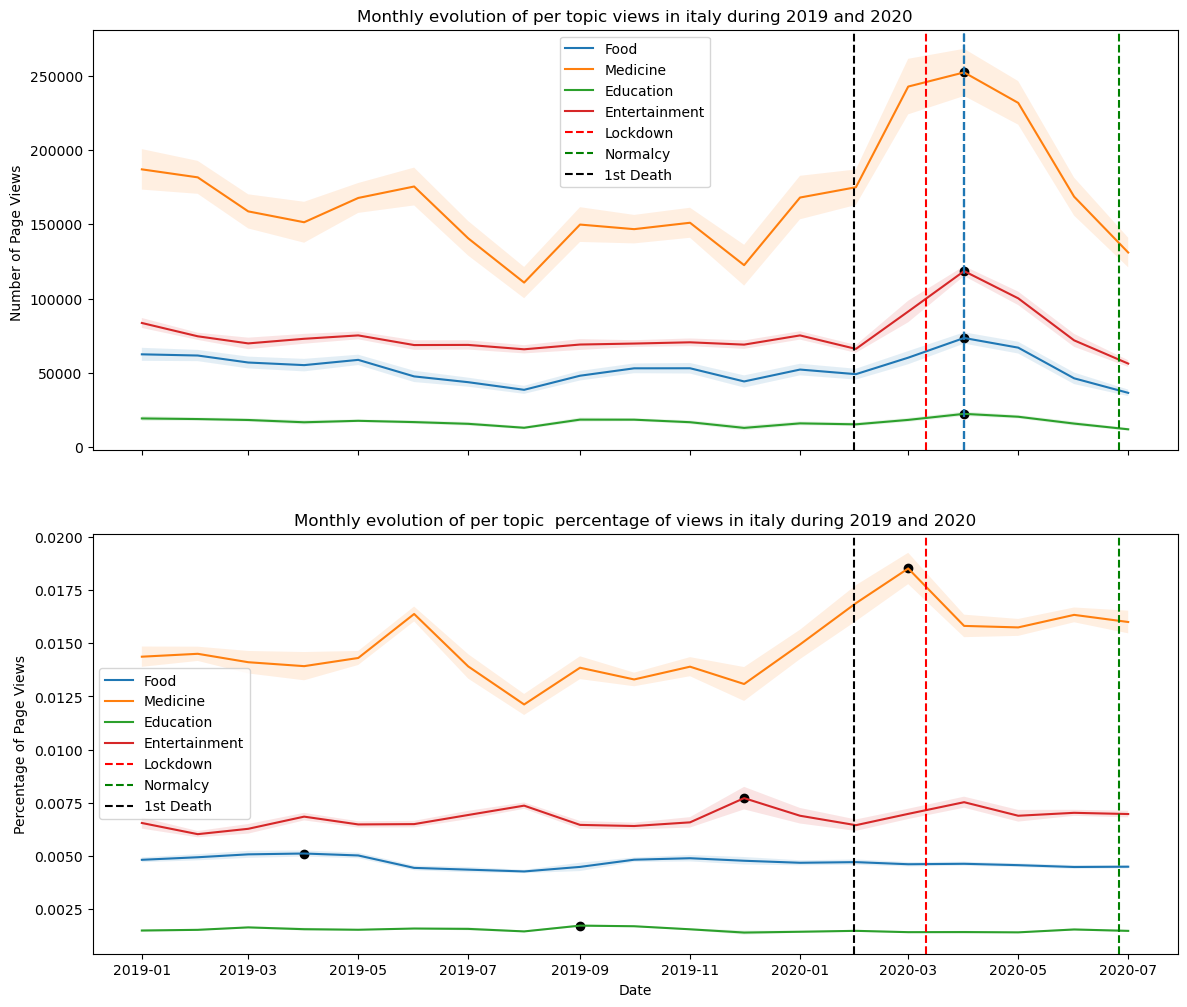

In [204]:
timeseries=[agg_ts['it']['topics']['Culture.Food and drink'],
    agg_ts['it']['topics']['STEM.Medicine & Health'],
    agg_ts['it']['topics']['History and Society.Education'],
    agg_ts['it']['topics']['Culture.Media.Entertainment']]
legends=['Food','Medicine','Education','Entertainment']
plt.figure(figsize=(14,6))
fig,axs=plt.subplots(2,1,figsize=(14,12),sharex=True)

for i,ts in enumerate(timeseries):
    
    df=process_agg_time_series(ts)
    df=df.loc[df['year'].isin([2020,2019])]
    
    df_means=df.groupby(['year','month'])['sum'].mean().copy()
    df_sem=df.groupby(['year','month'])['sum'].sem().copy()
    df_means.index=[datetime(e[0], e[1],1) for e in df_means.index]
    df_sem.index=[datetime(e[0], e[1],1) for e in df_sem.index]
    CI=stats.t.interval(0.95, len(df_means)-1 , loc = df_means, scale = df_sem)
    sns.lineplot(df_means,label=legends[i],ax=axs[0])
    axs[0].fill_between(df_means.index,CI[0],CI[1],alpha=0.12)
    axs[0].scatter(x=df_means.idxmax(),y=df_means.max(),color='black')
    axs[0].axvline(x=df_means.idxmax(), linestyle='--')
    axs[0].set_title('Monthly evolution of per topic views in italy during 2019 and 2020')
    axs[0].set_ylabel('Number of Page Views ')
    axs[0].set_xlabel('Dates')

    
    df_means=df.groupby(['year','month'])['percent'].mean().copy()
    df_sem=df.groupby(['year','month'])['percent'].sem().copy()
    df_means.index=[datetime(e[0], e[1],1) for e in df_means.index]
    df_sem.index=[datetime(e[0], e[1],1) for e in df_sem.index]
    CI=stats.t.interval(0.95, len(df_means)-1 , loc = df_means, scale = df_sem)
    sns.lineplot(df_means,label=legends[i],ax=axs[1])
    axs[1].fill_between(df_means.index,CI[0],CI[1],alpha=0.12)
    axs[1].scatter(x=df_means.idxmax(),y=df_means.max(),color='black')
    axs[1].set_title('Monthly evolution of per topic  percentage of views in italy during 2019 and 2020')
    axs[1].set_ylabel('Percentage of Page Views')   
    axs[1].set_xlabel('Date')    
    
for i in range(2):
    axs[i].axvline(x=[interventions['Lockdown'][3]],color='red', linestyle='--', label='Lockdown')
    axs[i].axvline(x=[interventions['Normalcy'][3]],color='green', linestyle='--', label='Normalcy')
    axs[i].axvline(x=[interventions['1st case'][3]],color='black', linestyle='--', label='1st Death')
    axs[i].legend()

plt.show()

#### Deeper look at how normalcy status affected the searches

##### General number of cases

###### Add  columns that specify the lockdown and normalcy status of italy (1 for lockdown/normalcy 0 otherwise)

In [205]:
it_lockdown_date=interventions['Lockdown'][3]
it_normalcy_date=interventions['Normalcy'][3]
it_first_death=interventions['Normalcy'][3]

In [206]:
it=process_agg_time_series(agg_ts['it']['sum'])
it['Lockdown_status']= np.where(it['date']>=it_lockdown_date,1,0)
it['Normalcy_status']=np.where(it['date']>=it_normalcy_date,1,0)
it

,sum,date,year,month,day,Lockdown_status,Normalcy_status
0,3338750,2018-01-01,2018,1,1,0,0
1,5428428,2018-01-02,2018,1,2,0,0
2,5640812,2018-01-03,2018,1,3,0,0
3,5794860,2018-01-04,2018,1,4,0,0
4,5475376,2018-01-05,2018,1,5,0,0
...,...,...,...,...,...,...,...
938,3796235,2020-07-27,2020,7,27,1,1
939,3609134,2020-07-28,2020,7,28,1,1
940,3460350,2020-07-29,2020,7,29,1,1
941,3676745,2020-07-30,2020,7,30,1,1


In [207]:
model=smf.ols(formula='sum~C(Lockdown_status)+C(Normalcy_status)',data=it)
res=model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    sum   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     117.7
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           2.38e-46
Time:                        15:10:12   Log-Likelihood:                -14329.
No. Observations:                 943   AIC:                         2.866e+04
Df Residuals:                     940   BIC:                         2.868e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                4

##### Specific case (e.g: food and drink)

In [208]:
food_drink=process_agg_time_series(agg_ts['it']['topics']['Culture.Food and drink'])
food_drink['Lockdown_status']= np.where(food_drink['date']>=it_lockdown_date,1,0)
food_drink['Normalcy_status']=np.where(food_drink['date']>=it_normalcy_date,1,0)

In [209]:
model=smf.ols(formula='sum~C(Lockdown_status)+C(Normalcy_status)',data=food_drink)
res=model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    sum   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     62.23
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           4.16e-26
Time:                        15:10:12   Log-Likelihood:                -10270.
No. Observations:                 943   AIC:                         2.055e+04
Df Residuals:                     940   BIC:                         2.056e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                5

In [210]:
model=smf.ols(formula='percent~C(Lockdown_status)+C(Normalcy_status)',data=food_drink)
res=model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                percent   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     51.45
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           6.23e-22
Time:                        15:10:12   Log-Likelihood:                 5905.3
No. Observations:                 943   AIC:                        -1.180e+04
Df Residuals:                     940   BIC:                        -1.179e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### Mobility

In [211]:
global_mr=pd.read_csv('DATA/Global_Mobility_Report.csv')
global_mr

C:\Users\alyel\AppData\Local\Temp\ipykernel_10640\3088372953.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  global_mr=pd.read_csv('DATA/Global_Mobility_Report.csv')


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111407,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-19,NaN,NaN,NaN,NaN,-9.0,NaN
2111408,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-20,NaN,NaN,NaN,NaN,-5.0,NaN
2111409,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-21,NaN,NaN,NaN,NaN,-5.0,NaN
2111410,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-24,NaN,NaN,NaN,NaN,-4.0,NaN


In [212]:
global_agg=global_mr.groupby('country_region_code').mean(numeric_only=True).drop(columns='census_fips_code')
global_agg

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
country_region_code,,,,,,
AE,-28.387306,-11.090026,-41.386380,-43.049442,-22.715674,14.878285
AF,-19.912162,-1.847973,-9.412162,-18.236486,-19.881757,7.885135
AG,-30.805699,-19.554404,-16.784974,-46.477231,-37.728155,13.721649
AO,-25.450633,-11.704225,-21.655440,-41.285366,-10.830010,14.616580
AR,-53.483347,-18.887372,-64.393354,-51.869822,-19.517832,15.258667
...,...,...,...,...,...,...
VN,-20.398234,-6.192182,-20.022184,-18.359323,1.945353,6.229507
YE,-2.005181,5.849741,-3.694301,-2.440415,-6.637306,4.284974
ZA,-33.098446,-16.607772,-19.333161,-41.013200,-26.366839,15.698964


In [213]:
global_agg.index
global_agg.index[0]
print('AE' in global_agg.index)

True


Splitting the dataframe by continents 

In [214]:
continents_column = []
global_agg_copy = global_agg.copy()

for i in range(len(global_agg_copy.index)) :
    current_code = global_agg_copy.index[i]
    found_region = 0
    for df in dfsContinents :
        if current_code in df['alpha-2'].values :
            found_region = df.iloc[0]['region']

    continents_column.append(found_region)

global_agg_copy['continents'] = continents_column


dfsGlobal_agg = []
for continent in continents :
    dfsGlobal_agg.append(global_agg_copy[global_agg_copy['continents'] == continent].copy())
dfsGlobal_agg[0]

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,continents
country_region_code,,,,,,,
AE,-28.387306,-11.090026,-41.386380,-43.049442,-22.715674,14.878285,Asia
AF,-19.912162,-1.847973,-9.412162,-18.236486,-19.881757,7.885135,Asia
BD,-38.440415,-21.129534,-16.849741,-35.730570,-23.968912,13.139896,Asia
BH,-29.393782,-10.891192,-29.077720,-26.932642,-18.678756,13.357513,Asia
GE,-33.729730,-16.641892,-9.003378,-30.047297,-33.658784,8.523649,Asia
HK,-23.440415,0.777202,-19.497409,-28.347150,-16.813472,13.145078,Asia
ID,-21.029608,-8.042783,-18.286751,-37.880817,-17.923464,10.029608,Asia
IL,-28.751295,-3.121573,3.747341,-21.240933,-27.032124,11.149234,Asia
IN,-49.746402,-13.997935,-30.734375,-29.826671,-22.546702,14.165025,Asia


In [215]:
global_agg

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
country_region_code,,,,,,
AE,-28.387306,-11.090026,-41.386380,-43.049442,-22.715674,14.878285
AF,-19.912162,-1.847973,-9.412162,-18.236486,-19.881757,7.885135
AG,-30.805699,-19.554404,-16.784974,-46.477231,-37.728155,13.721649
AO,-25.450633,-11.704225,-21.655440,-41.285366,-10.830010,14.616580
AR,-53.483347,-18.887372,-64.393354,-51.869822,-19.517832,15.258667
...,...,...,...,...,...,...
VN,-20.398234,-6.192182,-20.022184,-18.359323,1.945353,6.229507
YE,-2.005181,5.849741,-3.694301,-2.440415,-6.637306,4.284974
ZA,-33.098446,-16.607772,-19.333161,-41.013200,-26.366839,15.698964


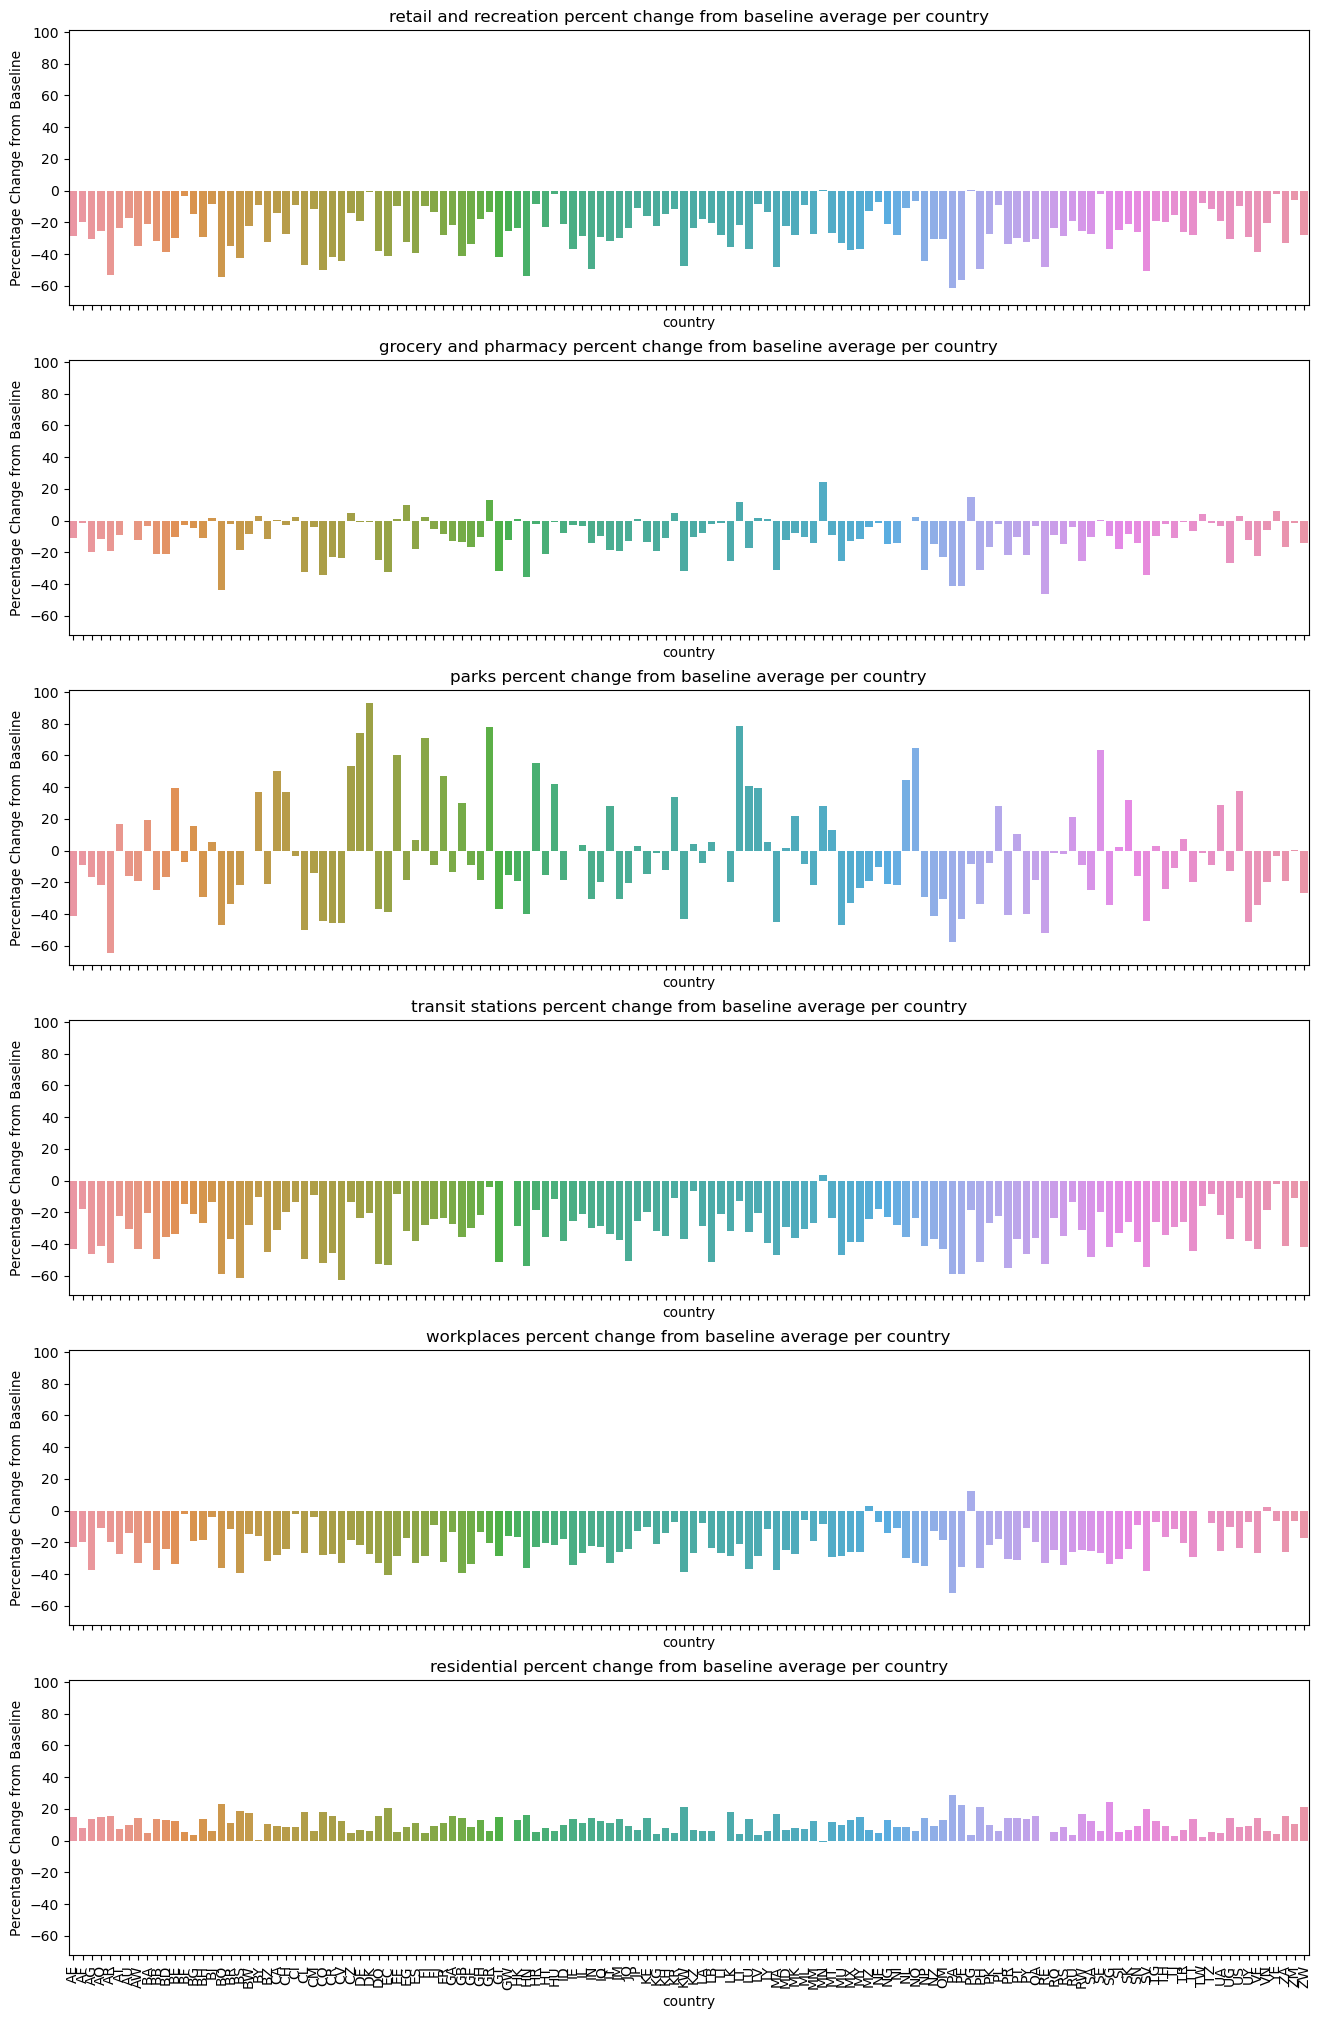

In [216]:
fig, axs= plt.subplots(6,1,sharey=True,sharex=True,figsize=(16,25))
for i, col in enumerate(global_agg.columns):
    ax=axs[i]
    sns.barplot(y=global_agg[col],x=global_agg.index,ax=ax)
    ax.set_xlabel('country')
    ax.set_ylabel('Percentage Change from Baseline')
    ax.set_xticklabels(global_agg.index,rotation=90)
    ax.set_title(str(col).replace('_'," ") + ' average per country')

plt.show()

    

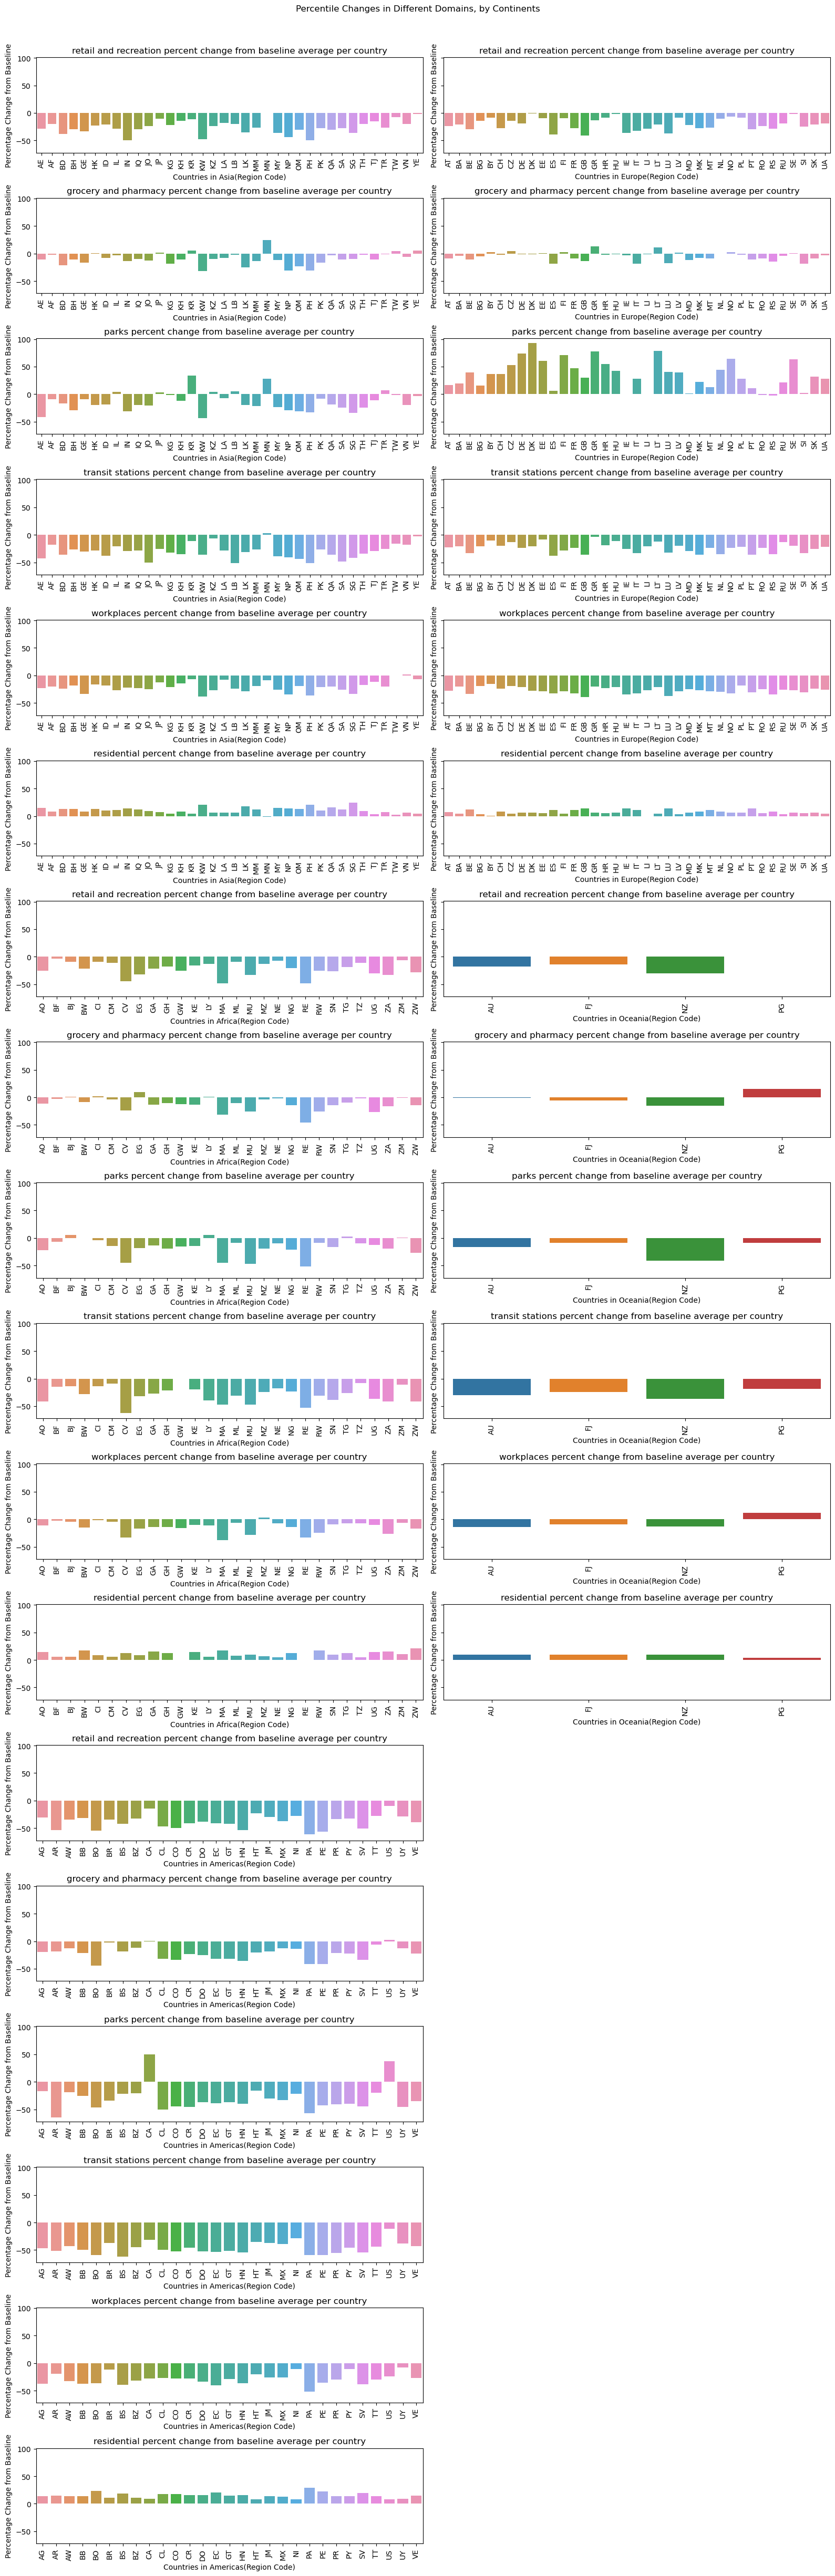

In [217]:
fig, axs= plt.subplots(18,2,sharey=True,sharex=False,figsize=(16,50))
og_columns = global_agg.columns
for j in range(len(dfsGlobal_agg)) :
    df = dfsGlobal_agg[j]
    for i, col in enumerate(og_columns):
        ax=axs[(j//2)*6 + i,j%2]
        sns.barplot(y=df[col],x=df.index,ax=ax)
        ax.set_xlabel('Countries in ' + continents[j] + '(Region Code)')
        ax.set_ylabel('Percentage Change from Baseline')
        ax.set_xticklabels(df.index, rotation=90)
        ax.set_title(str(col).replace('_'," ") + ' average per country')

for i in range (6) : 
    axs[12 + i, 1].set_visible(False)

plt.tight_layout()

# Fine-tune layout to create more space at the top
plt.subplots_adjust(top=0.96)

plt.suptitle('Percentile Changes in Different Domains, by Continents')
plt.show()

# Apple Mobility

In [218]:
apple_mr=pd.read_csv('DATA/applemobilitytrends-2020-04-20.csv')
apple_mr.describe
# apple_mr

<bound method NDFrame.describe of            geo_type         region transportation_type  2020-01-13  \
0    country/region        Albania             driving         100   
1    country/region        Albania             walking         100   
2    country/region      Argentina             driving         100   
3    country/region      Argentina             walking         100   
4    country/region      Australia             driving         100   
..              ...            ...                 ...         ...   
390            city  Washington DC             transit         100   
391            city  Washington DC             walking         100   
392            city         Zurich             driving         100   
393            city         Zurich             transit         100   
394            city         Zurich             walking         100   

     2020-01-14  2020-01-15  2020-01-16  2020-01-17  2020-01-18  2020-01-19  \
0         95.30      101.43       97.20      1

In [219]:
apple_mr.columns

Index(['geo_type', 'region', 'transportation_type', '2020-01-13', '2020-01-14',
       '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18', '2020-01-19',
       ...
       '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
       '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20'],
      dtype='object', length=102)

In [220]:
apple_mr

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
0,country/region,Albania,driving,100,95.30,101.43,97.20,103.55,112.67,104.83,...,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51
1,country/region,Albania,walking,100,100.68,98.93,98.46,100.85,100.13,82.13,...,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72
2,country/region,Argentina,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,...,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67
3,country/region,Argentina,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,...,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44
4,country/region,Australia,driving,100,102.98,104.21,108.63,109.08,89.00,99.35,...,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,city,Washington DC,transit,100,100.78,103.92,105.02,112.26,96.01,87.76,...,16.99,14.23,17.01,17.37,17.02,17.10,17.14,16.61,16.66,18.20
391,city,Washington DC,walking,100,99.07,109.61,104.16,123.16,119.71,106.28,...,44.63,32.84,33.58,37.56,38.69,37.76,42.50,41.80,43.51,41.89
392,city,Zurich,driving,100,102.38,110.84,105.48,113.83,109.67,102.03,...,63.78,54.97,67.09,72.52,74.89,77.13,78.01,73.62,71.97,73.74
393,city,Zurich,transit,100,101.51,108.93,97.87,103.91,98.50,93.83,...,29.18,31.49,32.90,35.71,35.68,33.65,36.77,36.75,37.66,37.50
